<!-- datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals -->

## Data summary

1. datetime - hourly date + timestamp  (num or cat)
2. season -  1 = spring, 2 = summer, 3 = fall, 4 = winter (cat)
3. holiday - whether the day is considered a holiday(cat)
4. workingday - whether the day is neither a weekend nor holiday(cat)
5. weather (cat, ordered )
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
6. temp - temperature in Celsius(num)
7. atemp - "feels like" temperature in Celsius(num-> cat)
8. humidity - relative humidity(num -> cat)
9. windspeed - wind speed(num -> cat)


#### label
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

## Evaluation

* RMSLE(Root Mean Squared Log Error)의 특징 vs RMSE
    1. 극단치에 비교적 자유롭다.Robust to Outlier
    2. 상대적 error를 측정해준다.relative error(log(x)-log(y)=log(x/y))
        * weak: when predict huge things, error from misepredict( 1billion to 100billion) is same with error from misprediction(1 to 100)
    3. 과소예측에 큰 페널티를 부여한다.bigger penalty to Under Estimation (shape of log function)

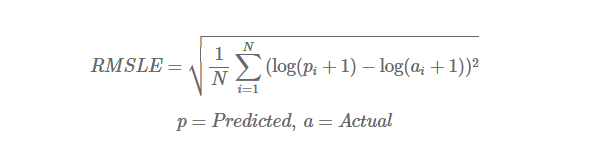

# 1. Data summary

### test
1. 관측값 10886, feature:12
2. 결측값 0
3. 중복값 0

###  train(casual, registered, count 가 없음)
1. 관측값 6483, feature:9
2. 결측값 0
3. 중복값 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

In [3]:
train= pd.read_csv('train.csv',parse_dates=['datetime'])

#feature 타입 확인
print(train.info())
print('='*50)
#data 살펴보기
print(train.sample(10))
print('='*50)
#결측값 확인
print(train.isnull().sum())
print('='*50)
#중복 데이터 확인
print(train.duplicated(['datetime'],keep='first').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None
                 datetime  season  holiday  workingday  weather   temp  \
6832  2012-04-03 00:00:00       2        0           1        1  16.

In [4]:
test=pd.read_csv('test.csv',parse_dates=['datetime'])
#feature 타입 확인
print(test.info())
print('='*50)
#data 살펴보기
print(test.sample(10))
print('='*50)
#결측값 확인
print(test.isnull().sum())
print('='*50)
#중복 데이터 확인
print(test.duplicated(['datetime'],keep='first').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB
None
                datetime  season  holiday  workingday  weather   temp   atemp  \
120  2011-01-25 04:00:00       1        0           1        1   5.74   8.335   
4268 2012-04-29 16:00:00       2        0           0        1  24.60  30.305   
2610 2011-10-29 07:00:00       4        0      

## 2. EDA

In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour

#datetime 열 제외
# train=train[train.columns.difference(['datetime'])]
print(train.shape)
print('='*50)

print(train.sample(5))
print('='*50)

train.info()

(10886, 16)
                 datetime  season  holiday  workingday  weather   temp  \
3768  2011-09-07 23:00:00       3        0           1        3  25.42   
4409  2011-10-15 18:00:00       4        0           0        1  22.14   
10643 2012-12-09 21:00:00       4        0           0        2  14.76   
2524  2011-06-13 02:00:00       2        0           1        1  25.42   
698   2011-02-12 10:00:00       1        0           0        1   9.02   

        atemp  humidity  windspeed  casual  registered  count  year  month  \
3768   27.275        94    12.9980       3          21     24  2011      9   
4409   25.760        39    12.9980     121         251    372  2011     10   
10643  18.180       100     7.0015      10          86     96  2012     12   
2524   29.545        73    19.0012       2           8     10  2011      6   
698    10.605        41    16.9979      13          71     84  2011      2   

       day  hour  
3768     7    23  
4409    15    18  
10643    9    21 

In [7]:
from IPython.display import set_matplotlib_formats

plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')

[Text(0.5, 0, 'day'), Text(0.5, 1.0, '일별 대여량')]

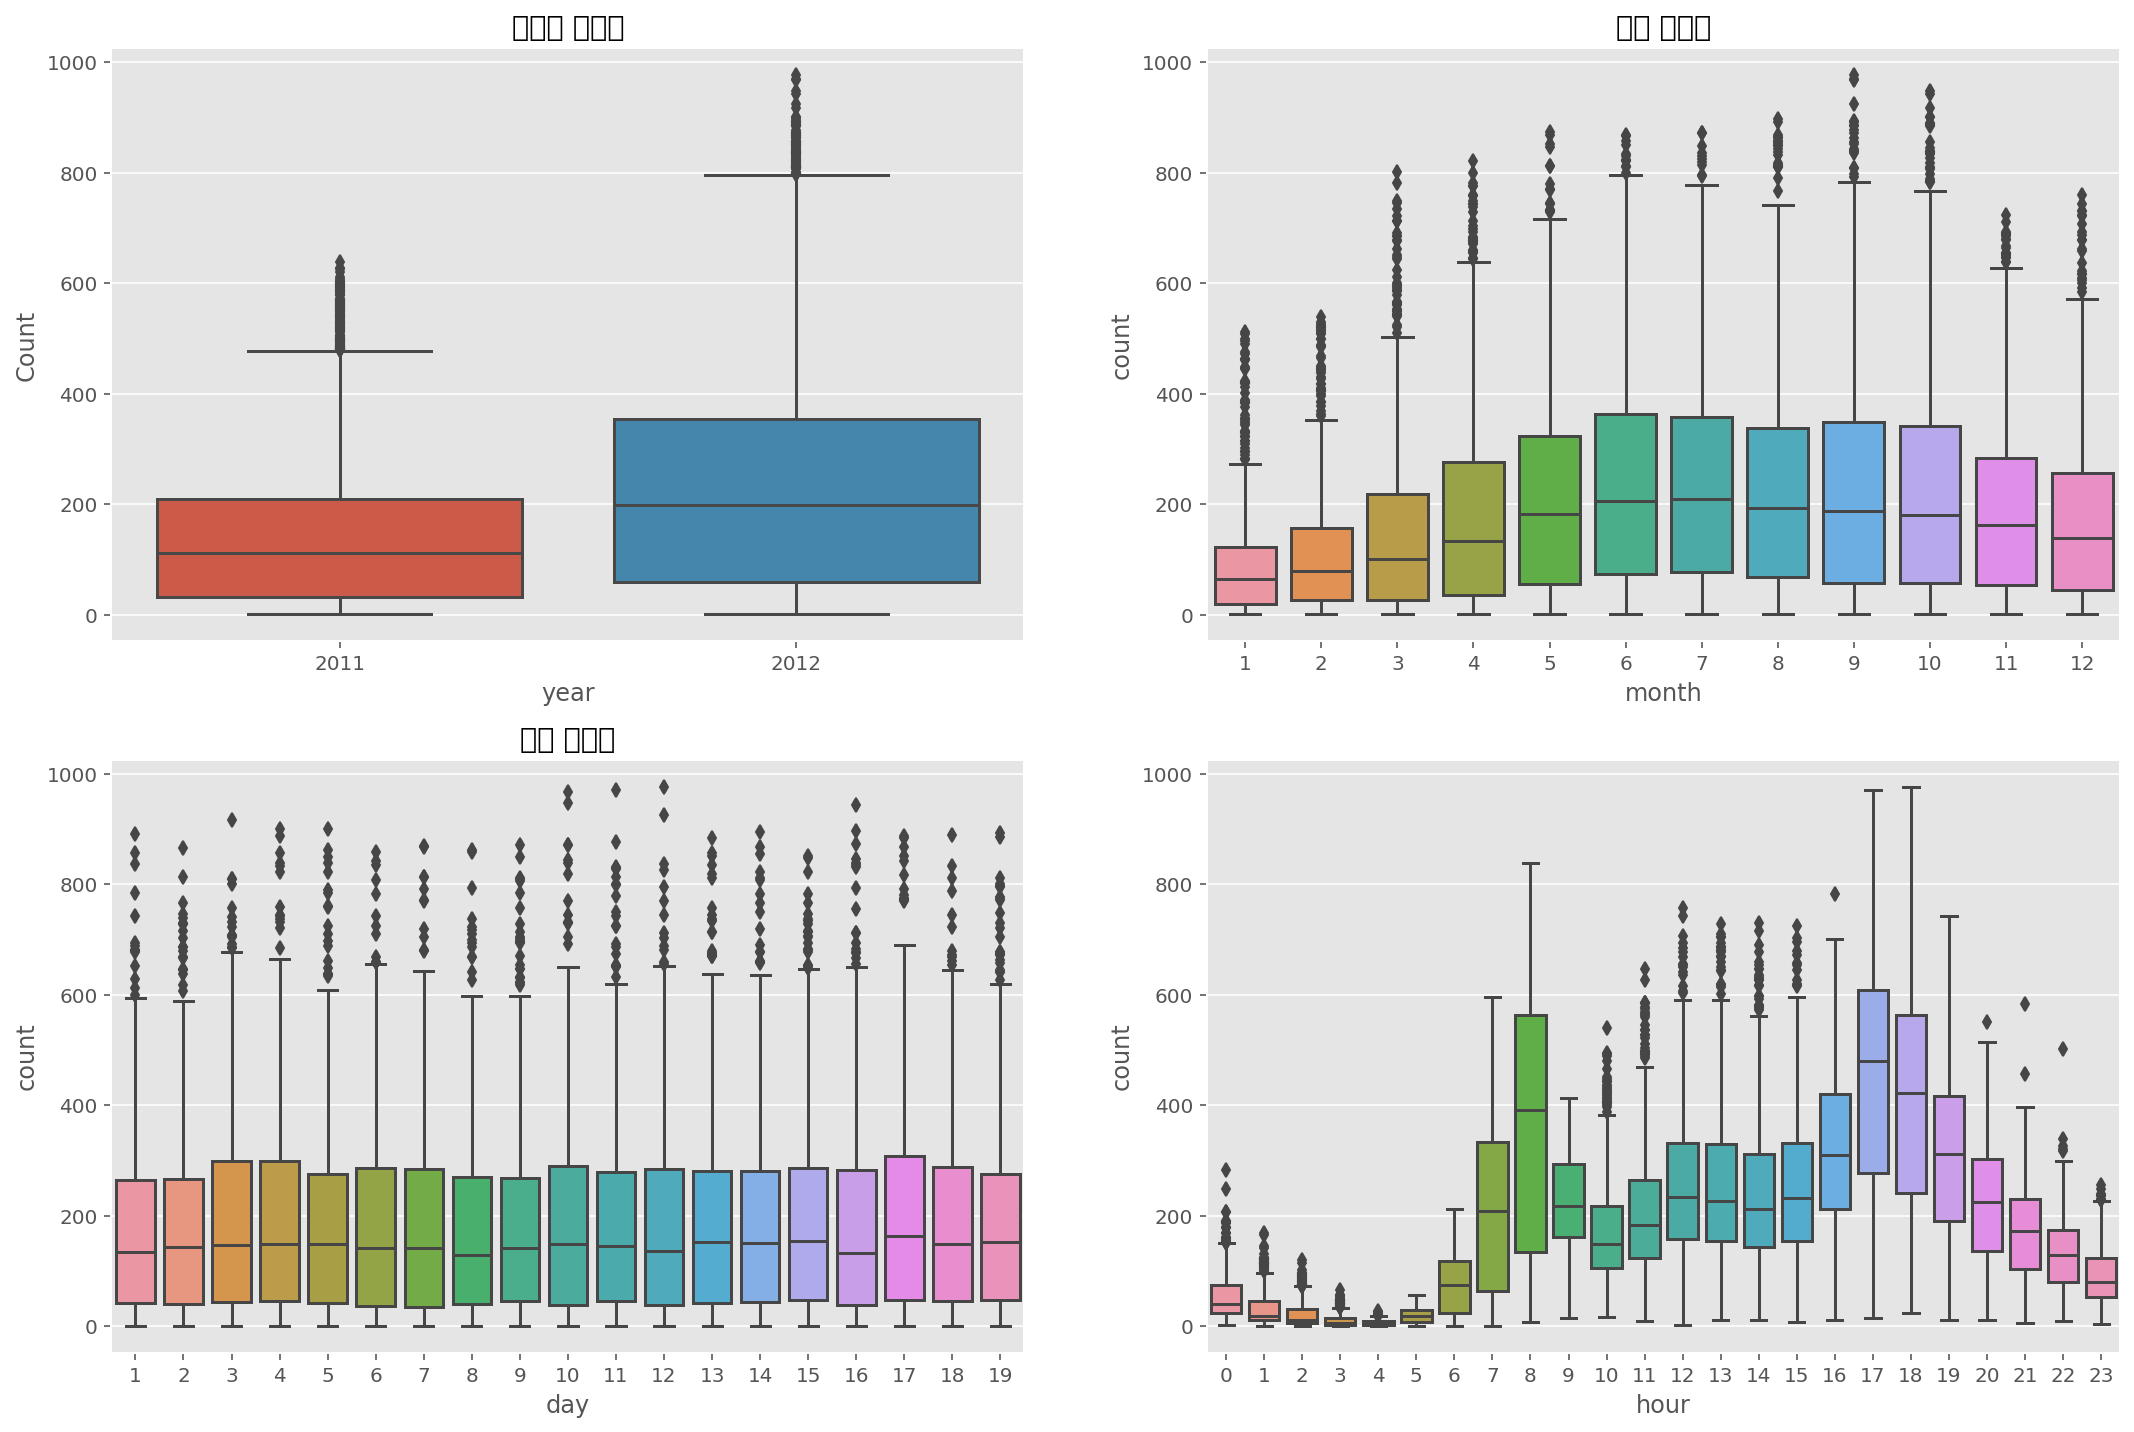

In [23]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
figure.set_size_inches(18,12)

sns.boxplot(data=train, x="year", y="count", ax=ax1)
sns.boxplot(data=train, x="month", y="count", ax=ax2)
sns.boxplot(data=train, x="day", y="count", ax=ax3)
sns.boxplot(data=train, x="hour", y="count", ax=ax4)


ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")


1. year-> factor
2. month -> 영향은 있지만, 계절이랑 날씨로 대체(다중공선성)
3. day-> test와 train이 다른 day라서 사용 불가능
4. hour 영향이 큼 주요 요인으로 사용, but 비선형관계 -> GAM사용

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

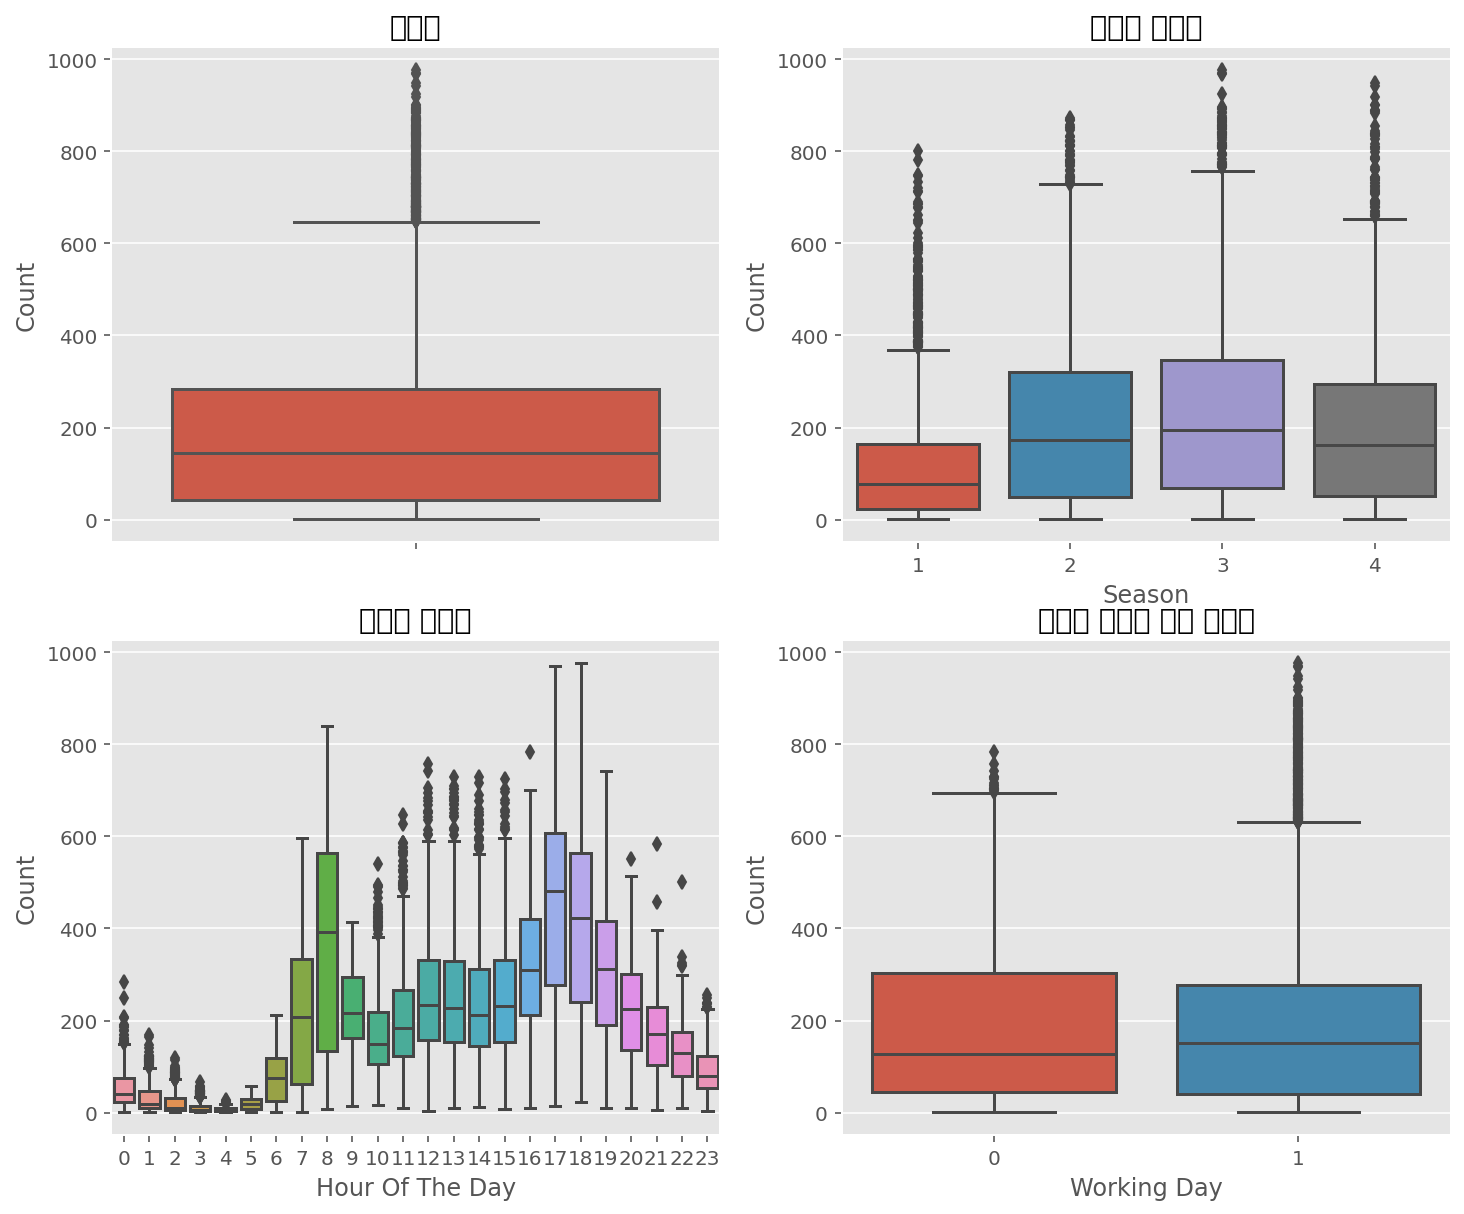

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

In [10]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

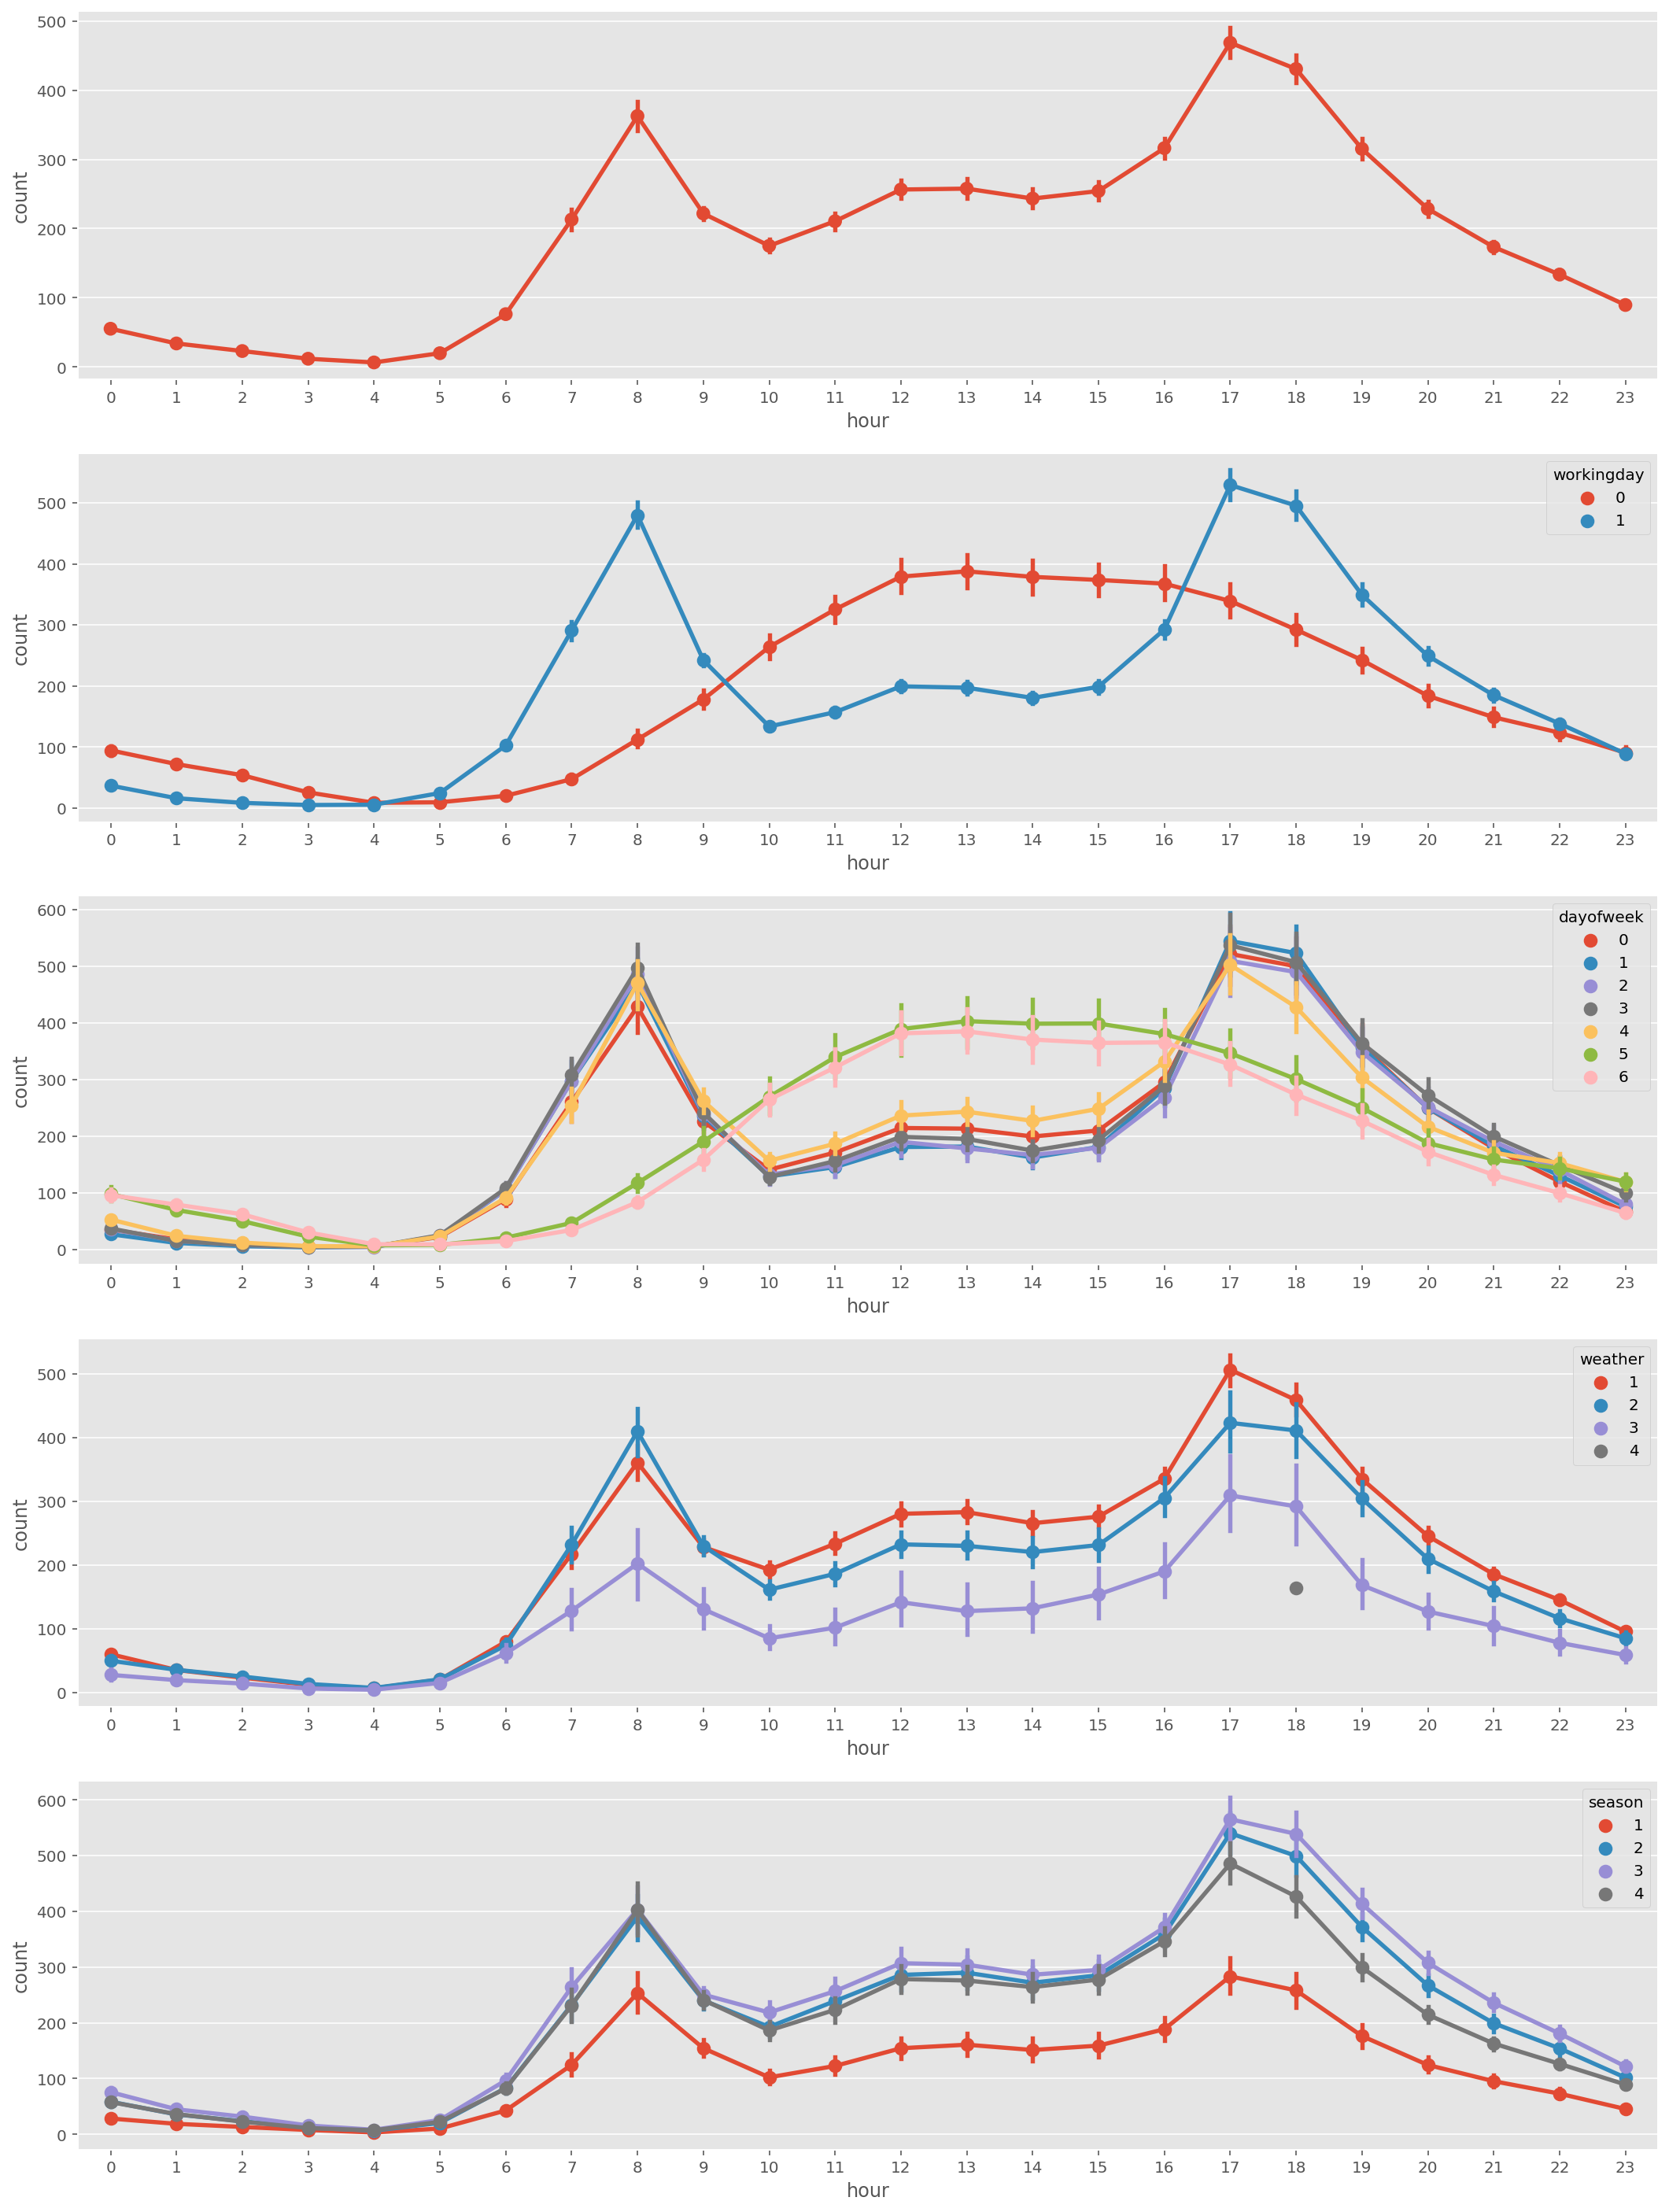

In [11]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

1. workingday 혹은 dayofweek 중 하나 선택해서 상호작용 피처, factor피처 넣기
2. weather에 factor  피처 넣기
3. hour을 factor로 할지 numeric으로 할지

<AxesSubplot:xlabel='humidity', ylabel='count'>

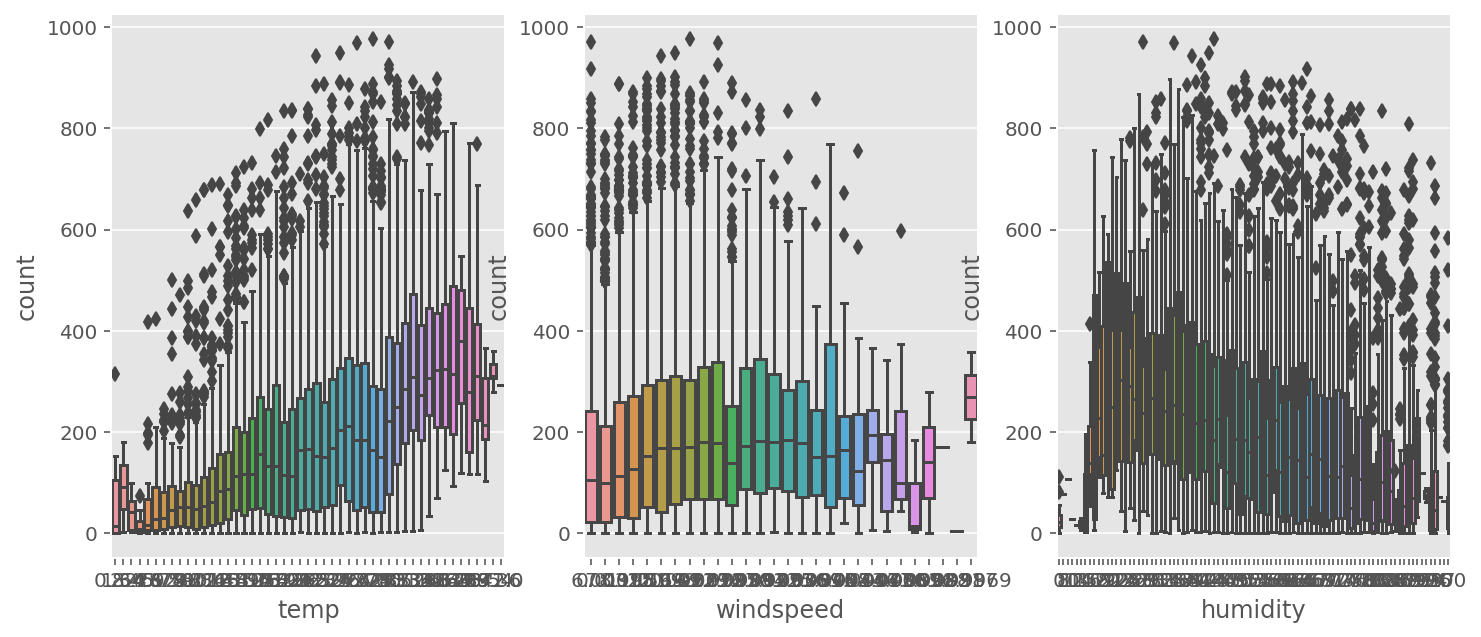

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.boxplot(x="temp", y="count", data=train,ax=ax1)
sns.boxplot(x="windspeed", y="count", data=train,ax=ax2)
sns.boxplot(x="humidity", y="count", data=train,ax=ax3)

<AxesSubplot:xlabel='humidity', ylabel='count'>

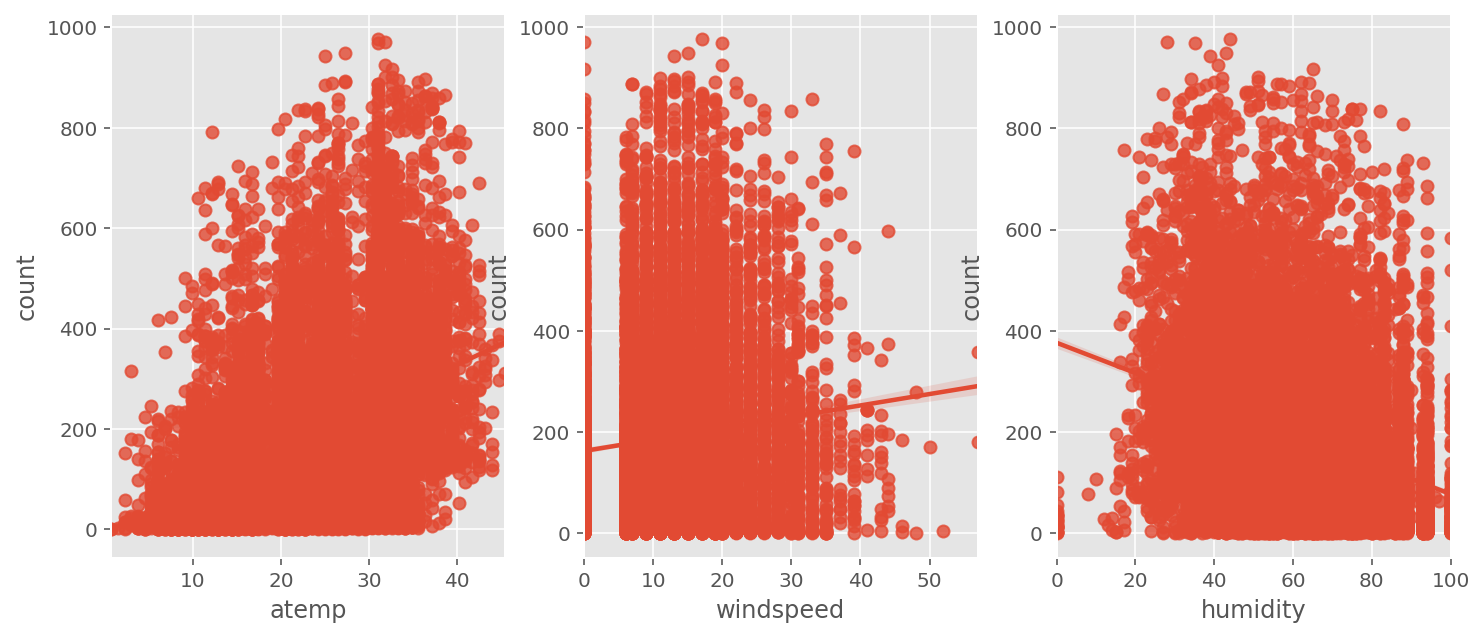

In [13]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="atemp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

1. windspeed 0 에 몰려있음 -> 결측치로 예상됨, 예측해서 채워주기
2. quantiletransform으로 스캐일링

In [14]:
train_scaled=train[['atemp','windspeed','humidity']]
train_scaled.head()

,atemp,windspeed,humidity
0,14.395,0.0,81
1,13.635,0.0,80
2,13.635,0.0,80
3,14.395,0.0,75
4,14.395,0.0,75


In [15]:
from sklearn.preprocessing import QuantileTransformer
scaler=QuantileTransformer()

train_scaled=scaler.fit_transform(train_scaled)


In [16]:
train_scaled=pd.DataFrame(train_scaled)

train_scaled.head()

,0,1,2
0,0.167668,0.0,0.796296
1,0.134635,0.0,0.785786
2,0.134635,0.0,0.785786
3,0.167668,0.0,0.711211
4,0.167668,0.0,0.711211


In [17]:
train_scaled.columns=['atemp','windspeed','humidity']
train_scaled.head()

,atemp,windspeed,humidity
0,0.167668,0.0,0.796296
1,0.134635,0.0,0.785786
2,0.134635,0.0,0.785786
3,0.167668,0.0,0.711211
4,0.167668,0.0,0.711211


In [18]:
train['count'].head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [19]:
train_scaled['count']=train['count']

In [20]:
train_scaled.head()

,atemp,windspeed,humidity,count
0,0.167668,0.0,0.796296,16
1,0.134635,0.0,0.785786,40
2,0.134635,0.0,0.785786,32
3,0.167668,0.0,0.711211,13
4,0.167668,0.0,0.711211,1


<AxesSubplot:xlabel='humidity', ylabel='count'>

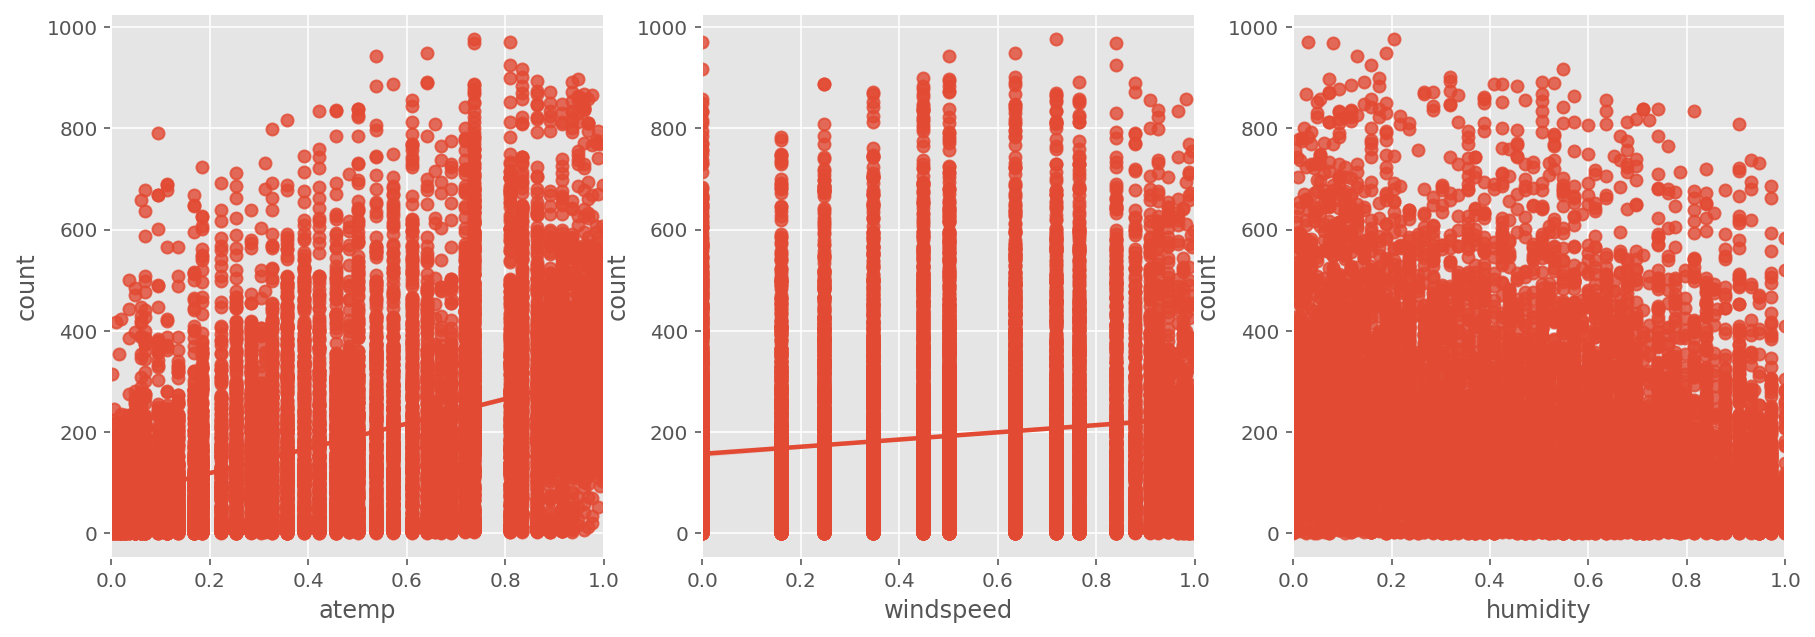

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(15, 5)
sns.regplot(x="atemp", y="count", data=train_scaled,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train_scaled,ax=ax2)
sns.regplot(x="humidity", y="count", data=train_scaled,ax=ax3)

1. temp(positive)와 humidity(negative) 선형관계가 보임
2. windspeed